In [ ]:
!pip install transformers
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install tensorflow-addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from transformers import TFBertModel, BertTokenizer
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import random
import re
import string
import os
from PIL import Image

In [ ]:
batch_size = 8
img_height = 224
img_width = 224
num_classes = 8

In [ ]:
image_ds_size = text_ds_size = 185

In [ ]:
def clear_text(text):
  '''
  remove punctuation, make text lower
  '''
  for char in string.punctuation + '_—„©‚':
    text = text.replace(char, ' ')
  text = ' '.join([w.lower() for w in text.split()])
  return text

In [ ]:
data_path = "/content/drive/MyDrive/Dataset_text"
data_dir = pathlib.Path(data_path).with_suffix('')

def get_texts_by_class(data_dir):
  # tuple (text, label)
  label_text_tuples = []
  folders = sorted([x for x in data_dir.iterdir() if x.is_dir()])
  for folder in folders:
    class_name = folder.parts[-1]
    files = sorted(folder.glob('*.txt'))
    for file in files:
      with open(file, 'r') as f:
        text = f.read().replace('\n', ' ')
        text = clear_text(text)
      label_text_tuples.append((class_name, text))

  return label_text_tuples

In [ ]:
text_label_tuples = get_texts_by_class(data_dir)

In [ ]:
# Using tokenizer for mapping text

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize(texts, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for text in texts:
        inputs = tokenizer(text, truncation=True, max_length=512, return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return input_ids, input_masks, input_segments


label_tokenized_text_tuples = []
texts = [x[1] for x in text_label_tuples]
ids, masks, token_types = tokenize(texts, tokenizer)

for i in range(len(text_label_tuples)):
  label_tokenized_text_tuples.append( (text_label_tuples[i][0], [ids[i], masks[i], token_types[i]]) )

In [ ]:
data_path = "/content/drive/MyDrive/Dataset_resized"
data_dir = pathlib.Path(data_path).with_suffix('')

def get_images_by_class(data_dir):
  # tuple (text, image)
  label_image_tuples = []
  folders = sorted([x for x in data_dir.iterdir() if x.is_dir()])
  for folder in folders:
    class_name = folder.parts[-1]
    files = sorted(folder.glob('*.jpg'))
    for image in files:
      with Image.open(image) as img:
        img = tf.convert_to_tensor(img)
      label_image_tuples.append((class_name, img))

  return label_image_tuples

In [ ]:
lable_image_tuples = get_images_by_class(data_dir)

In [ ]:
images = [x[1] for x in lable_image_tuples]
text_tokens = [x[1] for x in label_tokenized_text_tuples]
labels = [x[0] for x in lable_image_tuples]

In [ ]:
text_tokens[3]

[<tf.Tensor: shape=(1, 74), dtype=int32, numpy=
 array([[   101,  11963,    551,  20387,  10517, 100439,  10205,  10851,
            555,  11663,  18565,  17006,    557,  35912,  11579,    555,
          27332,  20928,  11980,  29482,  28171,  28445,  11980,  45117,
          10385,  65794,    555,  32246,  13701,  23339, 102167,  95301,
          10179,    555,    557,  10316,  45228,   1779,  10983,  34606,
          11815,    560,    549,  16176,  10475,  78070,  14525,    555,
            542,  51798,  98280,  10384,    561,  82562,  91390,    558,
          30318,  12528,  96655,  17371,  36712,  10179,    569,    549,
          38146,  14402,  35261,  10541,  77879,  11184,  85055,  10923,
            541,    102]], dtype=int32)>,
 <tf.Tensor: shape=(1, 74), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# converting text features to one shape (to max 512 len for now cuz I'm stupid)

def stretch_to_len(array, len=512):
  assert array.shape[0] == 1
  if array.shape[1] < len:
    array = np.pad(array, ((0, 0), (0, 512 - array.shape[1])), mode='constant', constant_values=0)
  return array

for i, features in enumerate(text_tokens):
  for j in range(len(features)):
    # also manually adding one dim to text features for bert model batching
    text_tokens[i][j] = stretch_to_len(text_tokens[i][j])


In [ ]:
from sklearn.model_selection import train_test_split

train_img_X, val_img_X, train_text_X, val_text_X, train_y, val_y = train_test_split(images, text_tokens, labels, test_size=0.2)


print(len(train_img_X), len(train_text_X), len(train_y))
print(len(val_img_X), len(val_text_X), len(val_y))

148 148 148
37 37 37


In [ ]:
def hand_made_one_hot(labels):
  unique_labels = []
  for label in labels:
    if label not in unique_labels:
      unique_labels.append(label)

  unique_labels.sort()
  ohe_labels = []
  for i, label in enumerate(labels):
    ohe_labels.append(np.zeros(len(unique_labels)))
    ohe_labels[i][unique_labels.index(label)] = 1

  return ohe_labels


In [ ]:
print(f'train_y before ohe: {train_y}')

train_y = hand_made_one_hot(train_y)
val_y = hand_made_one_hot(val_y)

print(f'train_y after ohe: {train_y}')

train_y before ohe: ['Military_ticket', 'marriage_certificate', 'Birth_certificate', 'employment_record', 'marriage_certificate', 'passport', 'Military_ticket', 'snils', 'marriage_certificate', 'passport', 'snils', 'passport', 'Military_ticket', 'passport', 'Birth_certificate', 'passport', 'passport', 'snils', 'Birth_certificate', 'marriage_certificate', 'Birth_certificate', 'snils', 'snils', 'Employment_contract', 'Pisnoe', 'Birth_certificate', 'Employment_contract', 'snils', 'employment_record', 'passport', 'Employment_contract', 'snils', 'passport', 'passport', 'snils', 'Employment_contract', 'passport', 'marriage_certificate', 'employment_record', 'employment_record', 'snils', 'employment_record', 'passport', 'Military_ticket', 'Birth_certificate', 'snils', 'Military_ticket', 'passport', 'Birth_certificate', 'passport', 'employment_record', 'marriage_certificate', 'Employment_contract', 'Military_ticket', 'Birth_certificate', 'passport', 'snils', 'employment_record', 'marriage_cert

In [ ]:

train_text_X = tf.convert_to_tensor(np.array(train_text_X))
train_img_X = tf.convert_to_tensor(train_img_X)
train_y = tf.convert_to_tensor(train_y)

val_text_X = tf.convert_to_tensor(np.array(val_text_X))
val_img_X = tf.convert_to_tensor(val_img_X)
val_y = tf.convert_to_tensor(val_y)

In [ ]:
train_text_X.shape, train_img_X.shape, train_y.shape, val_y.shape

(TensorShape([148, 3, 1, 512]),
 TensorShape([148, 224, 224, 3]),
 TensorShape([148, 8]),
 TensorShape([37, 8]))

In [ ]:
# define the CNN-based image feature extractor
def build_image_model():
    img_model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu')
    ])
    return img_model

In [ ]:
# define the BERT-based text feature extractor

def build_text_model(input_len=512):
    bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
    for layer in bert_model.layers:
      layer.trainable=False
      for w in layer.weights: w._trainable=False

    # change dummy input for bert
    dummy_ids = dummy_mask = dummy_types = tf.constant([[0] * input_len])
    bert_model._saved_model_inputs_spec = None
    for feature in [dummy_ids, dummy_mask, dummy_types]:
      bert_model._set_save_spec(feature)

    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids')
    input_attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask')
    input_token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='token_type_ids')

    outputs = bert_model(input_ids=input_ids, attention_mask=input_attention_mask, token_type_ids=input_token_type_ids)[1]
    text_model = tf.keras.Model(inputs=[input_ids, input_attention_mask, input_token_type_ids], outputs=outputs)
    return text_model

In [ ]:
# define the multimodal document classification model
def build_multimodal_model(num_classes):
    img_model = build_image_model()
    text_model = build_text_model()
    img_input = tf.keras.layers.Input(shape=(224, 224, 3), name='img_input')

    text_input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids')
    text_input_attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask')
    text_input_token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='token_type_ids')

    img_features = img_model(img_input)
    text_features = text_model(inputs=[text_input_ids, text_input_attention_mask, text_input_token_type_ids])
    concat_features = tf.keras.layers.concatenate([img_features, text_features])
    x = tf.keras.layers.Dense(512, activation='relu')(concat_features)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    multimodal_model = tf.keras.Model(inputs=[img_input, text_input_ids, text_input_attention_mask, text_input_token_type_ids], outputs=x)
    return multimodal_model

In [ ]:
# build the multimodal model
num_classes = 8
multimodal_model = build_multimodal_model(num_classes)
multimodal_model.summary()

# compile the model and train on the train set
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                        

In [ ]:
train_text_X[:, 0].shape, train_img_X.shape

(TensorShape([148, 1, 512]), TensorShape([148, 224, 224, 3]))

In [ ]:
tf.debugging.disable_traceback_filtering()

multimodal_model.fit([train_img_X, np.squeeze(train_text_X[:, 0]), np.squeeze(train_text_X[:, 1]), np.squeeze(train_text_X[:, 2])], train_y, epochs=20, batch_size=8,
                     validation_data=([val_img_X, np.squeeze(val_text_X[:, 0]), np.squeeze(val_text_X[:, 1]), np.squeeze(val_text_X[:, 2])], val_y))

Epoch 1/20
19/19 [==============================] - 38s 1s/step - loss: 2.2776 - accuracy: 0.1216 - val_loss: 2.0634 - val_accuracy: 0.2703
Epoch 2/20
19/19 [==============================] - 10s 520ms/step - loss: 2.0086 - accuracy: 0.2297 - val_loss: 2.3883 - val_accuracy: 0.1081
Epoch 3/20
19/19 [==============================] - 10s 515ms/step - loss: 2.0440 - accuracy: 0.3108 - val_loss: 1.7936 - val_accuracy: 0.1892
Epoch 4/20
19/19 [==============================] - 10s 519ms/step - loss: 1.9259 - accuracy: 0.2973 - val_loss: 1.9412 - val_accuracy: 0.1892
Epoch 5/20
19/19 [==============================] - 10s 520ms/step - loss: 1.8696 - accuracy: 0.2905 - val_loss: 1.8226 - val_accuracy: 0.2432
Epoch 6/20
19/19 [==============================] - 10s 510ms/step - loss: 1.7971 - accuracy: 0.4392 - val_loss: 1.6893 - val_accuracy: 0.4054
Epoch 7/20
19/19 [==============================] - 10s 513ms/step - loss: 1.7983 - accuracy: 0.3649 - val_loss: 1.7502 - val_accuracy: 0.2703
Ep

### Сохранение модели

In [ ]:
multimodal_model.save('/content/drive/MyDrive/multimodal_model')

In [ ]:
multimodal_model.save('/content/drive/MyDrive/multimodal_model.h5')

In [ ]:
reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/multimodal_model.h5')

ValueError: ignored

In [ ]:
reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/multimodal_model')

In [ ]:
reloaded_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                        

### Метрики

In [ ]:
# checking metrics f1, roc_auc, confusion_matrix
import tensorflow_addons as tfa

f1_metric = tfa.metrics.F1Score(num_classes=8, threshold=0.5)
y_pred = reloaded_model.predict(x=[val_img_X, np.squeeze(val_text_X[:, 0]), np.squeeze(val_text_X[:, 1]), np.squeeze(val_text_X[:, 2])])
y_pred.shape, val_y.shape

2/2 [==============================] - 3s 222ms/step


((37, 8), TensorShape([37, 8]))

In [ ]:
f1_metric.update_state(val_y, y_pred)
result = f1_metric.result()
result.numpy()

array([0.84210527, 1.        , 0.8       , 0.57142854, 1.        ,
       0.57142854, 0.5       , 1.        ], dtype=float32)

In [ ]:
roc_metric = tf.keras.metrics.AUC(num_thresholds=100)
roc_metric.update_state(val_y, y_pred)
roc_metric.result().numpy()

0.9181885

In [ ]:
from sklearn.metrics import confusion_matrix

y_val_labels = [np.where(x == 1)[0][0] for x in np.array(val_y)]
y_pred_labels = [np.argmax(x) for x in np.array(y_pred)]

conf_mx = confusion_matrix(y_val_labels, y_pred_labels)

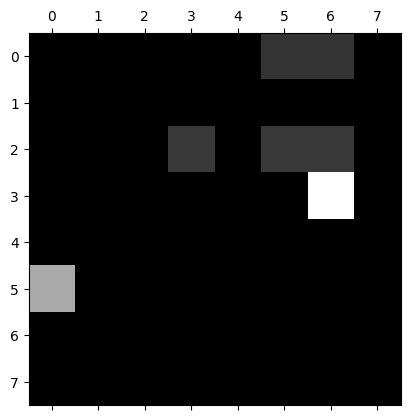

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
classes_list = sorted([x.parts[-1] for x in data_dir.iterdir() if x.is_dir()])
classes_list

['Birth_certificate',
 'Employment_contract',
 'Military_ticket',
 'Pisnoe',
 'employment_record',
 'marriage_certificate',
 'passport',
 'snils']